In [105]:
import os
import time
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import nltk
from nltk import sent_tokenize
from nltk import word_tokenize
from bs4 import BeautifulSoup
import spacy

from google.cloud import bigquery
from google.cloud.exceptions import NotFound
from google.cloud import storage
from google.colab import drive
from google.colab import files
from google.api_core import datetime_helpers

PROJECT_PATH = '/content/drive/MyDrive/Kaggle/bq-4-26'
TITANIC_PATH = '/content/drive/MyDrive/Kaggle/bq-4-26/titanic'
KEYS_PATH = '/content/drive/MyDrive/Kaggle/bq-4-26/keys'
KEY = 'kaggle-colab-4-26-3e8884497243.json'
KEY_PATH = os.path.join(KEYS_PATH, KEY)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = KEY_PATH

In [42]:
# !pip list

In [43]:
# os.chdir(KEYS_PATH)
# !pwd
# !ls

# Kaggle Setup

In [44]:
os.chdir('/content/drive/MyDrive/Kaggle')
!ls

# Upload kaggle API key file
# uploaded = files.upload()

bq-4-26  kaggle.json  tps_mar


In [45]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !ls ~/.kaggle

# !kaggle --version

In [46]:
# # Trends brain data download
# os.chdir(DATASET_PATH)
# !kaggle competitions download -c trends-assessment-prediction

In [47]:
# # titanic dataset download

# os.chdir(DATASET_PATH)
os.chdir('bq-4-26/titanic')
!pwd

# !kaggle competitions download -c titanic

/content/drive/MyDrive/Kaggle/bq-4-26/titanic


# Big Query Functions
Client object creation requires authentication setup <br>
https://cloud.google.com/bigquery/docs/reference/libraries

Using big query to take a csv from google drive and run some queries and dataframe transformations. <br>

Datasets can be created in BigQuery's GUI or by command.

In [48]:
%load_ext google.colab.data_table
# to revert back to standard data table display methods
# %unload_ext google.colab.data_table

# Setting API target
PROJECT_ID = 'kaggle-colab-4-26'
dataset_name = 'titanic'
table_name = 'train'

# Construct a bigquery client object
client = bigquery.Client(PROJECT_ID)

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


## Project Details

In [49]:
# List all datasets and tables in project
def listBQProjectElements(project_id):

  project = client.project
  datasets = client.list_datasets()

  # List datasets given project
  if datasets:
    print("Project: {}".format(project))
    for dataset in datasets:
      print("Datasets: {}".format(dataset.dataset_id))
      tables = client.list_tables(dataset.dataset_id)
      for table in tables:
        print("\t\tTables: {}".format(table.table_id))
  else:
    print("{} project does not contain any datasets".format(project))

# Output table properties
def getTableProperties(table_ref):
  table = client.get_table(table_ref)
  print("Schema:")
  display(table.schema)
  print("\nDescription:")
  display(table.description)
  print("\nNumber of Rows:")
  display(table.num_rows)

## Assigning Object Variables

In [50]:
# Assign dataset objects
def getDatasetObjects(dataset_name, display=True):
  dataset_id = client.project + "." + dataset_name
  dataset_ref = client.dataset(dataset_name)
  # dataset_fqid = bigquery.Dataset(dataset_id) # forced and object does not have attributes even though it prints the same
  dataset_fqid = client.get_dataset(dataset_ref) # same as dataset_fqid using reference isntead of id
  
  if display:
    print("Dataset ID (String): \t\t{}".format(dataset_id))
    print("Dataset Reference: \t\t{}".format(dataset_ref))
    print("Dataset Fully Qualified ID: \t{}".format(dataset_fqid))
 
  return dataset_id, dataset_ref, dataset_fqid


# Assign Table Objects
def getTableObjects(dataset_name, table_name, dislpay=True):
  dataset_id, dataset_ref, dataset_fqid = getDatasetObjects(dataset_name, display=False)
  table_id = dataset_id + "." + table_name
  table_ref = dataset_ref.table(table_name)
  # table_fqid = bigquery.Table(table_id) # forced and object does not have attributes even though it prints the same
  table_fqid = client.get_table(table_ref) # same as table_fqid using reference instead of table_id

  if display:
    print("Table ID (String): \t\t{}".format(table_id))
    print("Table Reference: \t\t{}".format(table_ref))
    print("Table Fully Qualified ID: \t{}".format(table_fqid))

  return table_id, table_ref, table_fqid

## Creation and Deletion

In [51]:
# Create new dataset
def createDataset(dataset_name):
# new_dataset = "new_dataset"
# client.create_dataset(new_dataset)
  pass


# Delete dataset
def deleteDataset(dataset_name):
  pass


# Create new table in dataset
def createTable(dataset_ref, table_name):
  table_ref = dataset_ref.table(table_name)
  if not doesTableExist(table_ref):
    table = bigquery.Table(table_ref)
    table = client.create_table(table)
    print("Table {} has been created.".format(table_name))


# Delete table in dataset
def deleteTable(dataset_ref, table_name):
  table_ref = dataset_ref.table(table_name)
  if doesTableExist(table_ref):
    table = bigquery.Table(table_ref)
    client.delete_table(table)
    print("Table {} has been deleted.".format(table_name))


# Creates table and populates with CSV contents in dataset
def populateTableFromCSV(dataset_fqid, table_fqid, file_csv=0):
  if not doesTableExist(table_fqid):
    print("ready to create table")
    job_config = bigquery.LoadJobConfig()
    job_config.source_format = bigquery.SourceFormat.CSV
    job_config.autodetect = True

    with open(file_csv, "rb") as source_file:
      job = client.load_table_from_file(source_file, table_fqid, job_config = job_config)
    
    job.result()
    print("Loaded {} rows into {}:{}.".format(job.output_rows, dataset_fqid.dataset_id, table_fqid.table_id))
  else:
    print("table already exists")


## Checks


In [52]:
# Check if dataset exists
def doesDatasetExist(dataset_fqid):
  try:
    client.get_dataset(dataset_fqid)
    print("Dataset {} exists.".format(dataset_fqid.dataset_id))
    return True
  except NotFound:
    print("Dataset {} not found.".format(dataset_fqid.dataset_id))


# Check if table exists
def doesTableExist(table_fqid):
  try:
    client.get_table(table_fqid)
    print("Table {} exists.".format(table_fqid.table_id))
    return True
  except NotFound:
    print("Table {} is not found.".format(table_fqid.table_id))

# Uploading Titanic Training Dataset to Big Query Dataset

First check the contents of the project tree


In [53]:
listBQProjectElements(PROJECT_ID)

Project: kaggle-colab-4-26
Datasets: titanic
		Tables: train


Assign object variables for the target dataset and table for ease of use in later functions. <br>

Documentation and errors may reference the ID in both string or fully-qualified notation.  This can be thought of as the difference between hostname vs FQDN.

In [54]:
titanic_id, titanic_ref, titanic_fqid = getDatasetObjects(dataset_name)
print("\n")
train_id, train_ref, train_fqid = getTableObjects(dataset_name, table_name)
print("\n")

# Verify dataset and table existence
doesDatasetExist(titanic_fqid)
doesTableExist(train_fqid)

Dataset ID (String): 		kaggle-colab-4-26.titanic
Dataset Reference: 		DatasetReference('kaggle-colab-4-26', 'titanic')
Dataset Fully Qualified ID: 	Dataset(DatasetReference('kaggle-colab-4-26', 'titanic'))


Table ID (String): 		kaggle-colab-4-26.titanic.train
Table Reference: 		TableReference(DatasetReference('kaggle-colab-4-26', 'titanic'), 'train')
Table Fully Qualified ID: 	Table(TableReference(DatasetReference('kaggle-colab-4-26', 'titanic'), 'train'))


Dataset titanic exists.
Table train exists.


True

The table will be deleted in order to perform a clean upload.<br>
Schema, description, and rows are verified.

In [55]:
deleteTable(titanic_fqid, "train")
populateTableFromCSV(titanic_fqid, train_fqid, 'train.csv')
print("\n")
getTableProperties(train_ref)

Table train exists.
Table train has been deleted.
Table train is not found.
ready to create table
Loaded 891 rows into titanic:train.


Schema:


[SchemaField('PassengerId', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('Survived', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('Pclass', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('Name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('Sex', 'STRING', 'NULLABLE', None, ()),
 SchemaField('Age', 'FLOAT', 'NULLABLE', None, ()),
 SchemaField('SibSp', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('Parch', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('Ticket', 'STRING', 'NULLABLE', None, ()),
 SchemaField('Fare', 'FLOAT', 'NULLABLE', None, ()),
 SchemaField('Cabin', 'STRING', 'NULLABLE', None, ()),
 SchemaField('Embarked', 'STRING', 'NULLABLE', None, ())]


Description:


None


Number of Rows:


891

## Saving Table Snapshot
Mistakes can be undone in multiple ways:
- Create and revert to a snapshot <br>
https://googleapis.dev/python/bigquery/latest/usage/tables.html

- Use decorators for time travel <br>
https://cloud.google.com/bigquery/docs/time-travel#restore-a-table

- Backup table to another table for external use <br>
https://medium.com/google-cloud/how-to-backup-a-bigquery-table-or-dataset-to-google-cloud-storage-and-restore-from-it-6ef7eb322c6d


In [56]:
# Creating a snapshot

def createTableSnapshot(table_id):
  snapshot_epoch = int(time.time() * 1000)
  print(snapshot_epoch)
  # Ensuring that the snapshot is newer than the creation of the table
  # Otherwise, revert to the creation of the table 
  table = client.get_table(table_id)

  created_epoch = datetime_helpers.to_milliseconds(table.created)
  if created_epoch > snapshot_epoch:
    snapshot_epoch = created_epoch

  return snapshot_epoch

def revertTableToSnapshot(dataset_id, table_id, snapshot_epoch, recovery_table_name):
  recovered_table_id = dataset_id + "." + recovery_table_name
  
  try:
    recovered_table_fqid = client.get_table(recovered_table_id)
    print("Table {} already exists".format(recovery_table_name))

  except NotFound:
    print("Table does not already exist. Recovering {}.".format(recovery_table_name))
      # Construct the restore-from table ID using a snapshot decorator.
    snapshot_table_id = "{}@{}".format(table_id, snapshot_epoch)

    # Construct and run a copy job.
    job = client.copy_table(
        snapshot_table_id,
        recovered_table_id,
        # Must match the source and destination tables location.
        location="US",
    )  # Make an API request.

    job.result()  # Wait for the job to complete.

    print(
        "Copied data from deleted table {} to {}".format(table_id, recovered_table_id)
    )


**Snapshot Test**

1. Verify project contents
2. Create a snapshot
3. Delete "train" table
4. Revert snapshot with new name "train2"
5. Verify project contents

In [57]:
# Verify project contents
listBQProjectElements(PROJECT_ID)

# Create a snapshot
print("\nTimestamp for snapshot:")
train_snapshot_4_28_2021_17_11 = createTableSnapshot(train_id)

Project: kaggle-colab-4-26
Datasets: titanic
		Tables: train

Timestamp for snapshot:
1620312882589


In [58]:
# Delete "train" table
deleteTable(titanic_ref, "train")


# Revert snapshot with new name "train2"
print("\n")
revertTableToSnapshot(titanic_id, train_id, train_snapshot_4_28_2021_17_11, "train2")

# Verify project contents
print("\n")
listBQProjectElements(PROJECT_ID)

Table train exists.
Table train has been deleted.


Table does not already exist. Recovering train2.
Copied data from deleted table kaggle-colab-4-26.titanic.train to kaggle-colab-4-26.titanic.train2


Project: kaggle-colab-4-26
Datasets: titanic
		Tables: train2


After verifying, the name can be reverted.  The only other method I'm aware of is to copy to a new dataset and/or table.

In [59]:
deleteTable(titanic_ref, "train2")

# recheck datasets
print("\n")
listBQProjectElements(PROJECT_ID)

# revert with original name
print("\n")
revertTableToSnapshot(titanic_id, train_id, train_snapshot_4_28_2021_17_11, "train")

# recheck datasets
print("\n")
listBQProjectElements(PROJECT_ID)

Table train2 exists.
Table train2 has been deleted.


Project: kaggle-colab-4-26
Datasets: titanic


Table does not already exist. Recovering train.
Copied data from deleted table kaggle-colab-4-26.titanic.train to kaggle-colab-4-26.titanic.train


Project: kaggle-colab-4-26
Datasets: titanic
		Tables: train


# Accessing Data

## Run A Query As An API Request Using Standard SQL

https://googleapis.dev/python/bigquery/latest/index.html

In [60]:
query = f"""
SELECT *
FROM {PROJECT_ID}.titanic.train
"""
query_job = client.query(query)
df1 = query_job.to_dataframe()
print(df1.shape)
df1.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,None,S
1,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
2,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,None,S
3,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,None,S
4,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,None,S


In [61]:
df1.sort_values('Fare', ascending=False).head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
847,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C
845,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,None,C
846,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
174,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
175,439,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0000,C23 C25 C27,S


## Run Query Using gbq And Pandas
https://cloud.google.com/bigquery/docs/pandas-gbq-migration

In [62]:
df2 = pd.io.gbq.read_gbq('''
  SELECT Name, SUM(Fare) As total
  FROM `kaggle-colab-4-26.titanic.train`
  GROUP BY Name
  ORDER BY total DESC
''', project_id=PROJECT_ID, dialect='standard')

df2.head()

,Name,total
0,"Ward, Miss. Anna",512.3292
1,"Cardeza, Mr. Thomas Drake Martinez",512.3292
2,"Lesurer, Mr. Gustave J",512.3292
3,"Fortune, Mr. Charles Alexander",263.0000
4,"Fortune, Mr. Mark",263.0000


## Paging Through Tables

https://cloud.google.com/bigquery/docs/paging-results

In [63]:
client.list_rows(train_fqid, selected_fields=train_fqid.schema[:3], max_results=5).to_dataframe()

,PassengerId,Survived,Pclass
0,180,0,3
1,264,0,1
2,278,0,2
3,303,0,3
4,414,0,2


# Big Query Public Dataset Exploration - Stack Overflow Dataset


List all tables from dataset

In [64]:
# def listBQProjectElements(project_id):

#   project = client.project
#   datasets = client.list_datasets()

#   # List datasets given project
#   if datasets:
#     print("Project: {}".format(project))
#     for dataset in datasets:
#       print("Datasets: {}".format(dataset.dataset_id))
#       tables = client.list_tables(dataset.dataset_id)
#       for table in tables:
#         print("\t\tTables: {}".format(table.table_id))
#   else:
#     print("{} project does not contain any datasets".format(project))

In [65]:
dataset_ref = client.dataset("stackoverflow", project="bigquery-public-data")
dataset = client.get_dataset(dataset_ref)
tables = list(client.list_tables(dataset))

for table in tables:
  print(table.table_id)
  table_ref = client.get_table(table)
  print(table_ref.num_rows)
  print(table_ref.description)
  display(table_ref.schema)


badges
39178976
None


[SchemaField('id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('user_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('class', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('tag_based', 'BOOLEAN', 'NULLABLE', None, ())]

comments
79220809
None


[SchemaField('id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('text', 'STRING', 'NULLABLE', None, ()),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('post_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('user_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('user_display_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('score', 'INTEGER', 'NULLABLE', None, ())]

post_history
138808451
None


[SchemaField('id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('post_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('post_history_type_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('revision_guid', 'STRING', 'NULLABLE', None, ()),
 SchemaField('user_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('text', 'STRING', 'NULLABLE', None, ()),
 SchemaField('comment', 'STRING', 'NULLABLE', None, ())]

post_links
7302589
None


[SchemaField('id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('link_type_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('post_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('related_post_id', 'INTEGER', 'NULLABLE', None, ())]

posts_answers
31169429
None


[SchemaField('id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('title', 'STRING', 'NULLABLE', None, ()),
 SchemaField('body', 'STRING', 'NULLABLE', None, ()),
 SchemaField('accepted_answer_id', 'STRING', 'NULLABLE', None, ()),
 SchemaField('answer_count', 'STRING', 'NULLABLE', None, ()),
 SchemaField('comment_count', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('community_owned_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('favorite_count', 'STRING', 'NULLABLE', None, ()),
 SchemaField('last_activity_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('last_edit_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('last_editor_display_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('last_editor_user_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('owner_display_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('owner_user_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('parent_id', '

posts_moderator_nomination
334
None


[SchemaField('id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('title', 'STRING', 'NULLABLE', None, ()),
 SchemaField('body', 'STRING', 'NULLABLE', None, ()),
 SchemaField('accepted_answer_id', 'STRING', 'NULLABLE', None, ()),
 SchemaField('answer_count', 'STRING', 'NULLABLE', None, ()),
 SchemaField('comment_count', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('community_owned_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('favorite_count', 'STRING', 'NULLABLE', None, ()),
 SchemaField('last_activity_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('last_edit_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('last_editor_display_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('last_editor_user_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('owner_display_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('owner_user_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('parent_id', '

posts_orphaned_tag_wiki
167
None


[SchemaField('id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('title', 'STRING', 'NULLABLE', None, ()),
 SchemaField('body', 'STRING', 'NULLABLE', None, ()),
 SchemaField('accepted_answer_id', 'STRING', 'NULLABLE', None, ()),
 SchemaField('answer_count', 'STRING', 'NULLABLE', None, ()),
 SchemaField('comment_count', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('community_owned_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('favorite_count', 'STRING', 'NULLABLE', None, ()),
 SchemaField('last_activity_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('last_edit_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('last_editor_display_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('last_editor_user_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('owner_display_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('owner_user_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('parent_id', '

posts_privilege_wiki
2
None


[SchemaField('id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('title', 'STRING', 'NULLABLE', None, ()),
 SchemaField('body', 'STRING', 'NULLABLE', None, ()),
 SchemaField('accepted_answer_id', 'STRING', 'NULLABLE', None, ()),
 SchemaField('answer_count', 'STRING', 'NULLABLE', None, ()),
 SchemaField('comment_count', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('community_owned_date', 'STRING', 'NULLABLE', None, ()),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('favorite_count', 'STRING', 'NULLABLE', None, ()),
 SchemaField('last_activity_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('last_edit_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('last_editor_display_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('last_editor_user_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('owner_display_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('owner_user_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('parent_id', 'STR

posts_questions
20890054
None


[SchemaField('id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('title', 'STRING', 'NULLABLE', None, ()),
 SchemaField('body', 'STRING', 'NULLABLE', None, ()),
 SchemaField('accepted_answer_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('answer_count', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('comment_count', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('community_owned_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('favorite_count', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('last_activity_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('last_edit_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('last_editor_display_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('last_editor_user_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('owner_display_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('owner_user_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('parent_id'

posts_tag_wiki
53036
None


[SchemaField('id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('title', 'STRING', 'NULLABLE', None, ()),
 SchemaField('body', 'STRING', 'NULLABLE', None, ()),
 SchemaField('accepted_answer_id', 'STRING', 'NULLABLE', None, ()),
 SchemaField('answer_count', 'STRING', 'NULLABLE', None, ()),
 SchemaField('comment_count', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('community_owned_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('favorite_count', 'STRING', 'NULLABLE', None, ()),
 SchemaField('last_activity_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('last_edit_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('last_editor_display_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('last_editor_user_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('owner_display_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('owner_user_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('parent_id', '

posts_tag_wiki_excerpt
53036
None


[SchemaField('id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('title', 'STRING', 'NULLABLE', None, ()),
 SchemaField('body', 'STRING', 'NULLABLE', None, ()),
 SchemaField('accepted_answer_id', 'STRING', 'NULLABLE', None, ()),
 SchemaField('answer_count', 'STRING', 'NULLABLE', None, ()),
 SchemaField('comment_count', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('community_owned_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('favorite_count', 'STRING', 'NULLABLE', None, ()),
 SchemaField('last_activity_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('last_edit_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('last_editor_display_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('last_editor_user_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('owner_display_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('owner_user_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('parent_id', '

posts_wiki_placeholder
5
None


[SchemaField('id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('title', 'STRING', 'NULLABLE', None, ()),
 SchemaField('body', 'STRING', 'NULLABLE', None, ()),
 SchemaField('accepted_answer_id', 'STRING', 'NULLABLE', None, ()),
 SchemaField('answer_count', 'STRING', 'NULLABLE', None, ()),
 SchemaField('comment_count', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('community_owned_date', 'STRING', 'NULLABLE', None, ()),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('favorite_count', 'STRING', 'NULLABLE', None, ()),
 SchemaField('last_activity_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('last_edit_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('last_editor_display_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('last_editor_user_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('owner_display_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('owner_user_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('parent_id', 'STR

stackoverflow_posts
31017889
Don't use this table - use posts_* instead


[SchemaField('id', 'INTEGER', 'REQUIRED', None, ()),
 SchemaField('title', 'STRING', 'NULLABLE', None, ()),
 SchemaField('body', 'STRING', 'NULLABLE', None, ()),
 SchemaField('accepted_answer_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('answer_count', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('comment_count', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('community_owned_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('favorite_count', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('last_activity_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('last_edit_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('last_editor_display_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('last_editor_user_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('owner_display_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('owner_user_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('parent_id'

tags
60534
None


[SchemaField('id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('tag_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('count', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('excerpt_post_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('wiki_post_id', 'INTEGER', 'NULLABLE', None, ())]

users
14080580
None


[SchemaField('id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('display_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('about_me', 'STRING', 'NULLABLE', None, ()),
 SchemaField('age', 'STRING', 'NULLABLE', None, ()),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('last_access_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('location', 'STRING', 'NULLABLE', None, ()),
 SchemaField('reputation', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('up_votes', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('down_votes', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('views', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('profile_image_url', 'STRING', 'NULLABLE', None, ()),
 SchemaField('website_url', 'STRING', 'NULLABLE', None, ())]

votes
208557841
None


[SchemaField('id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('post_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('vote_type_id', 'INTEGER', 'NULLABLE', None, ())]

Tables to investigate: Valuable columns<br>
- badges: date, name, user_id, class
- post_history: id, date, user_id, text
- post_answers: id, body, creation_date, score
- posts_questions: id, title, body, aceepted_answer_id, answer_count, comment_count, creation_date, favorit_count, score, tags, view_count
- posts_tag_wiki
- posts_tag_wiki_excerpt
- tags: id, count, excerpt_post_id, wiki_post_id
- users: id, reputation, up_votes, down_votes, website_url


## Posts Answers

In [66]:
# so_posts_answers_count = pd.io.gbq.read_gbq('''
#   SELECT COUNT(*)
#   FROM `bigquery-public-data.stackoverflow.posts_answers` 
#   WHERE creation_date BETWEEN TIMESTAMP("2020-04-01") AND TIMESTAMP("2021-04-01")
#   LIMIT 1000
# ;
# ''', project_id=PROJECT_ID, dialect='standard')

# display(so_posts_answers_count.head())

# so_posts_answers_df = pd.io.gbq.read_gbq('''
#   SELECT *
#   FROM `bigquery-public-data.stackoverflow.posts_answers` 
#   WHERE creation_date BETWEEN TIMESTAMP("2020-04-01") AND TIMESTAMP("2021-04-01")
#   LIMIT 1000
# ;
# ''', project_id=PROJECT_ID, dialect='standard')

# so_posts_answers_df.head(1)

In [67]:
so_posts_answers_df.describe()

NameError: ignored

In [ ]:
so_posts_answers_df.isna().sum()

## Posts Questions

In [ ]:
# so_posts_questions_count = pd.io.gbq.read_gbq('''
#   SELECT COUNT(*)
#   FROM `bigquery-public-data.stackoverflow.posts_questions` 
#   WHERE creation_date BETWEEN TIMESTAMP("2020-04-01") AND TIMESTAMP("2021-04-01")
#   LIMIT 1000
# ;
# ''', project_id=PROJECT_ID, dialect='standard')

# display(so_posts_questions_count.head())

# so_posts_questions_df = pd.io.gbq.read_gbq('''
#   SELECT *
#   FROM `bigquery-public-data.stackoverflow.posts_questions` 
#   WHERE creation_date BETWEEN TIMESTAMP("2020-04-01") AND TIMESTAMP("2021-04-01")
#   LIMIT 1000
# ;
# ''', project_id=PROJECT_ID, dialect='standard')

# so_posts_questions_df.head(1)

In [ ]:
so_posts_questions_df.describe()

In [ ]:
so_posts_questions_df.isna().sum()

## Questions and Answers min/max between April '16 and April '21 
For all questions that have an accepted answer

In [ ]:
# so_QA_min_max = pd.io.gbq.read_gbq('''
#  SELECT
#     MIN(pq.view_count) AS q_min_views, MAX(pq.view_count) AS q_max_views, 
#     MIN(pq.score) AS q_min_score, MAX(pq.score) AS q_max_score,
#     MIN(pq.favorite_count) AS q_min_fav, MAX(pq.favorite_count) AS q_max_fav, 
#     MIN(pq.answer_count) AS q_min_answers, MAX(pq.answer_count) AS q_max_answers,
#     MIN(pq.comment_count) AS q_min_comment_count, MAX(pq.comment_count) AS q_max_comment_count, 

#     MIN(pa.view_count) AS a_min_views, MAX(pa.view_count) AS a_max_views, 
#     MIN(pa.score) AS a_min_score, MAX(pa.score) AS a_max_score,
#     MIN(pa.comment_count) AS a_min_comment_count, MAX(pa.comment_count) AS a_max_comment_count, 
# FROM `bigquery-public-data.stackoverflow.posts_questions` AS pq
# JOIN `bigquery-public-data.stackoverflow.posts_answers` AS pa ON pq.accepted_answer_id = pa.id
# WHERE pq.creation_date BETWEEN TIMESTAMP("2016-04-01") AND TIMESTAMP("2021-04-01")
# ;
# ''', project_id=PROJECT_ID, dialect='standard')

# so_QA_min_max

## <font color='red'>Questions With Accepted Answers (JOINED)</font>


In [ ]:


# so_posts_QA_df = pd.io.gbq.read_gbq('''
# SELECT pq.title, pq.body AS post_question, pa.body AS post_answer, pq.answer_count AS question_answers, 
#         pq.comment_count AS question_comments, pa.comment_count AS answer_comments, pq.creation_date, pq.last_activity_date, 
#         pq.score AS question_score, pa.score AS answer_score, pq.tags, pq.view_count AS question_view_count
# FROM `bigquery-public-data.stackoverflow.posts_answers` AS pa
# INNER JOIN (
#     SELECT *
#     FROM `bigquery-public-data.stackoverflow.posts_questions`
#     WHERE accepted_answer_id IS NOT NULL
#     AND creation_date BETWEEN TIMESTAMP("2016-04-01") AND TIMESTAMP("2021-04-01")
# ) AS pq ON pa.id = pq.accepted_answer_id
# WHERE RAND() < 200000 / 4362034

# -- can also join to find the owner of the answer
# ;
# ''', dialect='standard')

# so_posts_QA_df.head(2)

In [ ]:
so_posts_QA_df.isna().sum()

In [ ]:
so_posts_QA_df.shape
so_posts_QA_df['question_score'].describe()
so_posts_QA_df.info()

### Saving dataframes as parquet and feather formats 

In [ ]:
# Navigate to google drive location

os.chdir('/content/drive/MyDrive/Kaggle/bq-4-26/stackoverflow')
!ls

In [ ]:
# Save file as parquet
#so_posts_QA_df.to_parquet('so_posts_QA_df.parquet.gzip', compression='gzip')

so_posts_QA_df.to_parquet('so_posts_QA_parquet.parquet.gzip', compression='gzip')

# Save file as feather
so_posts_QA_df.to_feather('so_posts_QA_feather')

In [ ]:
# Read back parquet file and verify column types

so_posts_QA = pd.read_parquet('so_posts_QA_parquet.parquet.gzip')
so_posts_QA.info()

In [ ]:
# read back feather file and verify column types

so_posts_QA_feather_df = pd.read_feather('so_posts_QA_feather')
so_posts_QA_feather_df.info()

### Distribution of numerical values 
- question_answers
- question_comments
- answer_comments
- question_score
- answer_score
- question_view_count

In [ ]:
# Count Plot


plt.figure(figsize=(15,10))
sns.countplot(x='answer_score', data=so_posts_QA_df)
plt.yscale("log")
plt.xscale("linear")
plt.xlim(-25, 250)
ticks = range(-24, 300, 15)
plt.xticks(ticks)
plt.show()


In [ ]:
plt.figure()
sns.kdeplot(so_posts_QA_df["answer_score"])
plt.yscale("log")
plt.show()

In [ ]:
plt.figure()
sns.countplot(x='answer_score', data=so_posts_QA_df)
plt.yscale("log")
plt.xscale("log")
plt.show()

In [ ]:
# subplots of all cont features in so_posts_QA_df

cont_features = ['question_answers', 'question_view_count', 'question_comments', 'answer_comments', 'question_score', 'answer_score']
plt.subplots(3,2, figsize=(10,15))
plt.suptitle('distribution of continuous features')

for i, col in enumerate(cont_features, 1):
  plt.subplot(3,2,i)
  sns.countplot(x=so_posts_QA_df[col])
  xrange = range(so_posts_QA_df[col].min(), so_posts_QA_df[col].max(), round((so_posts_QA_df[col].max()-so_posts_QA_df[col].min())/15) )
  plt.title(col)
  plt.xticks(xrange)
  plt.yscale("log")
plt.tight_layout
plt.show()

## Posts Tag Wiki Excerpt

In [ ]:
# so_posts_tag_wiki_excerpt_count = pd.io.gbq.read_gbq('''
#   SELECT COUNT(*) as full_count
#   FROM `bigquery-public-data.stackoverflow.posts_tag_wiki_excerpt` 
# ;
# ''', project_id=PROJECT_ID, dialect='standard')

# display(so_posts_tag_wiki_excerpt_count.head())

# so_posts_tag_wiki_excerpt_df = pd.io.gbq.read_gbq('''
#   SELECT *
#   FROM `bigquery-public-data.stackoverflow.posts_tag_wiki_excerpt` 
#   WHERE creation_date BETWEEN TIMESTAMP("2020-04-01") AND TIMESTAMP("2021-04-01")
#   LIMIT 1000
# ;
# ''', project_id=PROJECT_ID, dialect='standard')

# so_posts_tag_wiki_excerpt_df.head(1)

In [ ]:
so_posts_tag_wiki_excerpt_df.isna().sum()

## Tags

In [ ]:
# so_tags_count = pd.io.gbq.read_gbq('''
#   SELECT COUNT(*) as full_count
#   FROM `bigquery-public-data.stackoverflow.tags` 
# ;
# ''', project_id=PROJECT_ID, dialect='standard')

# display(so_tags_count.head())

# so_tags_df = pd.io.gbq.read_gbq('''
#   SELECT *
#   FROM `bigquery-public-data.stackoverflow.tags` 
#   LIMIT 1000
# ;
# ''', project_id=PROJECT_ID, dialect='standard')

# so_tags_df.head(1)

In [ ]:
so_tags_df.describe()

In [ ]:
so_tags_df.isna().sum()

## All Tags And Excerpts (JOINED)

In [ ]:
# so_tags_full = pd.io.gbq.read_gbq('''
# SELECT t.tag_name, te.body, t.count, te.comment_count, te.creation_date, te.last_activity_date, te.score, 
# FROM `bigquery-public-data.stackoverflow.posts_tag_wiki_excerpt` AS te
# JOIN `bigquery-public-data.stackoverflow.tags` as t ON te.id = t.excerpt_post_id
# ;
# ''',dialect='standard')

# so_tags_full.info()

# so_tags_full.head(2)

## Users

In [ ]:
# so_users_count = pd.io.gbq.read_gbq('''
#   SELECT COUNT(*) as five_year_count
#   FROM `bigquery-public-data.stackoverflow.users` 
#   WHERE creation_date BETWEEN TIMESTAMP("2016-04-01") AND TIMESTAMP("2021-04-01")
# ;
# ''', project_id=PROJECT_ID, dialect='standard')

# display(so_users_count.head())

# so_users_df = pd.io.gbq.read_gbq('''
#   SELECT *
#   FROM `bigquery-public-data.stackoverflow.users` 
#   WHERE creation_date BETWEEN TIMESTAMP("2020-04-01") AND TIMESTAMP("2021-04-01")
#   LIMIT 1000
# ;
# ''', project_id=PROJECT_ID, dialect='standard')

# so_users_df.head(1)

In [ ]:
so_users_df.describe()

In [ ]:
so_users_df['reputation'].unique()

In [ ]:
so_users_df.info()

## Badges

In [ ]:
# so_badges_count = pd.io.gbq.read_gbq('''
#   SELECT COUNT(*)
#   FROM `bigquery-public-data.stackoverflow.badges` 
#   WHERE date BETWEEN TIMESTAMP("2020-04-01") AND TIMESTAMP("2021-04-01")
#   LIMIT 1000
# ;
# ''', project_id=PROJECT_ID, dialect='standard')

# display(so_badges_count.head())

# so_badges_df = pd.io.gbq.read_gbq('''
#   SELECT *
#   FROM `bigquery-public-data.stackoverflow.badges` 
#   WHERE date BETWEEN TIMESTAMP("2020-04-01") AND TIMESTAMP("2021-04-01")
#   LIMIT 1000
# ;
# ''', project_id=PROJECT_ID, dialect='standard')

# so_badges_df.head(1)

In [ ]:
so_badges_df['name'].unique()

-- LIST USERS IN THE LAST 10 YEARS.
-- : MOST UPVOTES, MOST BADGES (STRING_AGG), 

In [ ]:
so_user_badges = pd.io.gbq.read_gbq('''
  SELECT b.user_id, u.display_name,
      STRING_AGG(DISTINCT b.name, ", ") AS applied_badges,
      SUM(u.down_votes) AS total_downvotes,
      SUM(u.up_votes) AS total_upvotes,
      SUM(u.reputation) AS total_reputation
  FROM `bigquery-public-data.stackoverflow.users` AS u
  JOIN `bigquery-public-data.stackoverflow.badges` AS b ON u.id = b.user_id
  WHERE u.creation_date BETWEEN TIMESTAMP("2011-04-01") AND TIMESTAMP("2021-04-01")
  GROUP BY b.user_id, u.display_name
  ORDER BY total_reputation DESC 
  LIMIT 300000
  ;
''', project_id=PROJECT_ID, dialect='standard')

In [ ]:
so_user_badges.shape

## Final Queries for NLP EDA

- Questions and accepted answers in last 5 years with 'python' tag
- tags with the most 'count'

In [106]:
os.chdir('/content/drive/MyDrive/Kaggle/bq-4-26/stackoverflow')
!pwd
!ls

/content/drive/MyDrive/Kaggle/bq-4-26/stackoverflow
so_posts_QA_df.parquet.gzip  so_posts_QA_feather  so_QA_tags.gzip


In [107]:
# so_QA_tags_df = pd.io.gbq.read_gbq('''
# SELECT pq.title, pq.body AS post_question, pa.body AS post_answer, pq.answer_count AS question_answers, 
#        pq.comment_count AS question_comments, pa.comment_count AS answer_comments, pq.creation_date, pq.last_activity_date, 
#        pq.score AS question_score, pa.score AS answer_score, pq.tags, pq.view_count AS question_view_count
# FROM `bigquery-public-data.stackoverflow.posts_answers` AS pa
# INNER JOIN (
#     SELECT *
#     FROM `bigquery-public-data.stackoverflow.posts_questions`
#     WHERE accepted_answer_id IS NOT NULL
#     AND creation_date BETWEEN TIMESTAMP("2016-04-01") AND TIMESTAMP("2021-04-01")
#     AND tags LIKE "%python%"
# ) AS pq ON pa.id = pq.accepted_answer_id
# WHERE RAND() < 200000 / 586000
# ''', dialect='standard') 

# print(so_QA_tags_df.shape)

# so_QA_tags_df.to_parquet("so_QA_tags.gzip", compression='gzip')

In [108]:
so_QA_tags = pd.read_parquet("so_QA_tags.gzip")
so_QA_tags.head(2)

,title,post_question,post_answer,question_answers,question_comments,answer_comments,creation_date,last_activity_date,question_score,answer_score,tags,question_view_count
0,"Click: Customize ""Missing argument"" error hand...",<p>I´m currently trying to customize the error...,<p>This is a first draft and the most naive so...,1,4,3,2020-04-27 17:54:28.800000+00:00,2020-04-28 20:43:47.557000+00:00,1,1,python|command-line-interface|command-line-arg...,143
1,'list' object is not callable for checking sco...,<p>I am creating a model using SVM. I wanted t...,<p>You create lists:</p>\n<pre><code>accuracy ...,1,2,0,2020-07-14 06:42:41.183000+00:00,2020-07-16 14:20:51.563000+00:00,2,2,python|scikit-learn|jupyter|svm|confusion-matrix,129


# Query Types

- JOIN
- UNION
- GROUP CONCAT
- COALESCE
- LAG, LEAD
- CASE/WHEN/THEN/ELSE, IF/ELSEIF/ELSE
<br>

- String Manipulation
- Datetime Manipulation
- Aggregate Functions
<br>

- Subqueries
- Window Functions
  - PARTITION BY
- CTE (Common Table Expressions)



# NLP
How does the question content and accepted answer content affect the following metrics?:
- upvotes
- downvotes
- reputation
- badges


**Regression** <br>

*Logistic*
1. Can the question title and body be enough to predict the majority of votes (up/down).  Whether the post is good or bad.
<br>

*Linear*
1. Assuming a good post, can the number of views be predicted depending on how long the question has been live?  This will require some feature engineering to know the number of years a question has been around.

2. Is there a trend in certain techniques/keywords for certain tags?

*Unsupervised Clustering*
1. Which tags have the most activity in the last 5 years?

## Question/Answer title and body analysis using NLP libraries

- beautiful soup: Parse through HTML and clean up tags
- create new column for links and if links were included
- nltk: tokenization
- spacy: independent effort

-- remove \n nextline
-- remove punctuation
-- stopwords
-- create word cloud for tags
-- stemming
-- lemmatization



In [109]:

print(so_QA_tags.shape)
so_QA_tags.head(2)

(199679, 12)


,title,post_question,post_answer,question_answers,question_comments,answer_comments,creation_date,last_activity_date,question_score,answer_score,tags,question_view_count
0,"Click: Customize ""Missing argument"" error hand...",<p>I´m currently trying to customize the error...,<p>This is a first draft and the most naive so...,1,4,3,2020-04-27 17:54:28.800000+00:00,2020-04-28 20:43:47.557000+00:00,1,1,python|command-line-interface|command-line-arg...,143
1,'list' object is not callable for checking sco...,<p>I am creating a model using SVM. I wanted t...,<p>You create lists:</p>\n<pre><code>accuracy ...,1,2,0,2020-07-14 06:42:41.183000+00:00,2020-07-16 14:20:51.563000+00:00,2,2,python|scikit-learn|jupyter|svm|confusion-matrix,129


In [110]:
print(so_QA_tags.shape)
so_QA_tags.describe().T

(199679, 12)


,count,mean,std,min,25%,50%,75%,max
question_answers,199679.0,1.571487,0.973870,1.0,1.0,1.0,2.0,32.0
question_comments,199679.0,1.862519,2.520400,0.0,0.0,1.0,3.0,47.0
answer_comments,199679.0,1.514401,2.318252,0.0,0.0,1.0,2.0,61.0
question_score,199679.0,1.188222,5.993023,-22.0,0.0,0.0,1.0,1296.0
answer_score,199679.0,2.137170,8.225570,-5.0,0.0,1.0,2.0,1643.0
question_view_count,199679.0,1211.418161,7036.489821,7.0,52.0,137.0,676.0,965492.0


In [111]:
print(so_QA_tags.question_view_count.median())
print(so_QA_tags.question_view_count.mode())

137.0
0    37
dtype: int64


#### Distribution for views

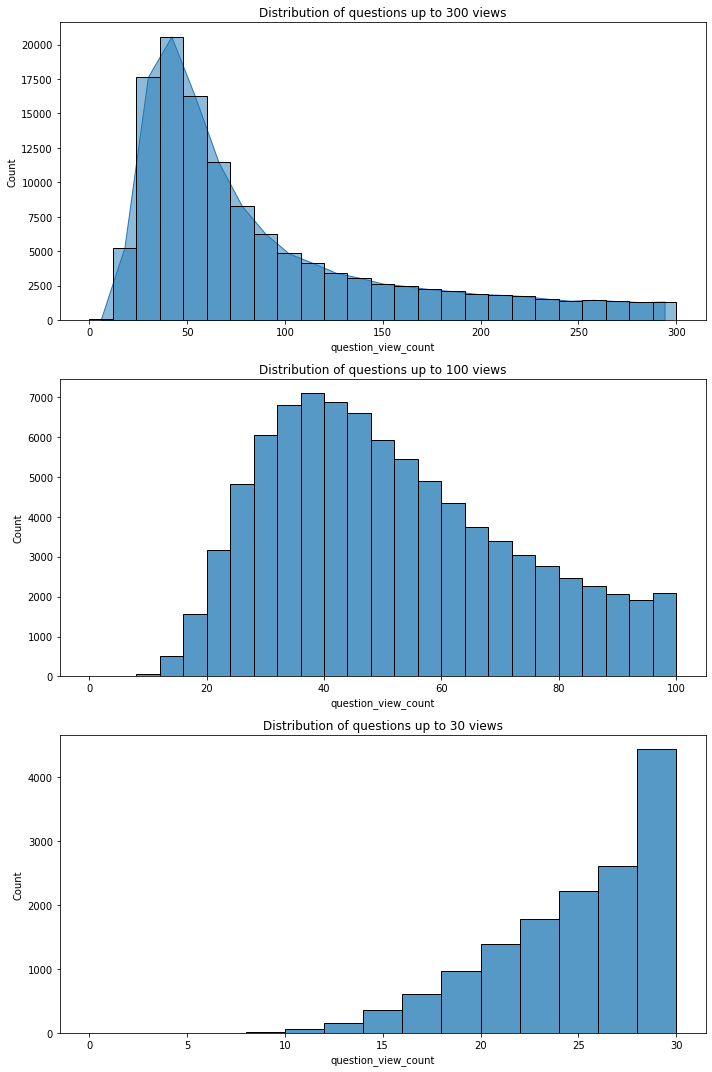

In [112]:
fig, axes = plt.subplots(3, 1, figsize=(10,15))

ax1 = axes[0]
ax1.set_title('Distribution of questions up to 300 views')
sns.histplot(x='question_view_count', data=so_QA_tags, binrange=(0,300), bins=25, ax=ax1, alpha=.5)
sns.histplot(x='question_view_count', data=so_QA_tags, element='poly', binrange=(0,300), bins=25, ax=ax1, alpha=.5)

ax2 = axes[1]
ax2.set_title('Distribution of questions up to 100 views')
sns.histplot(x='question_view_count', data=so_QA_tags, binrange=(0,100), bins=25, ax=ax2)

ax3 = axes[2]
ax3.set_title('Distribution of questions up to 30 views')
sns.histplot(x='question_view_count', data=so_QA_tags, binrange=(0,30), bins=15, ax=ax3)

plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

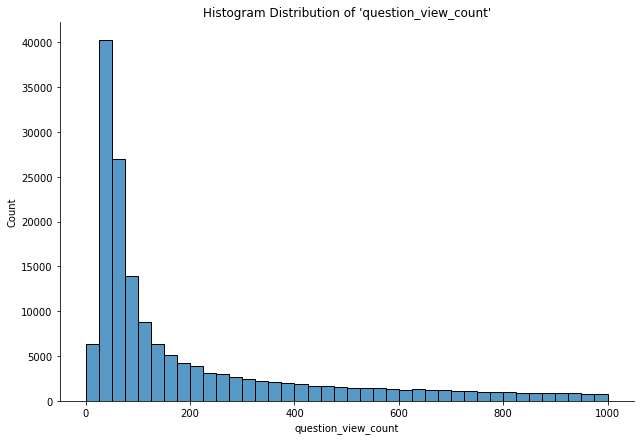

In [113]:
# fig, ax = plt.subplots(figsize=(10,15))
plt.figure()
sns.displot(so_QA_tags['question_view_count'], kind='hist', binrange=(0,1000), bins=40, height=6, aspect=1.5)
plt.title("Histogram Distribution of 'question_view_count'")
plt.show()



<Figure size 432x288 with 0 Axes>

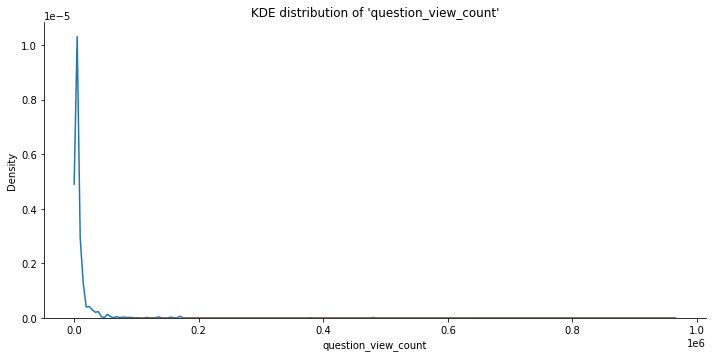

<Figure size 432x288 with 0 Axes>

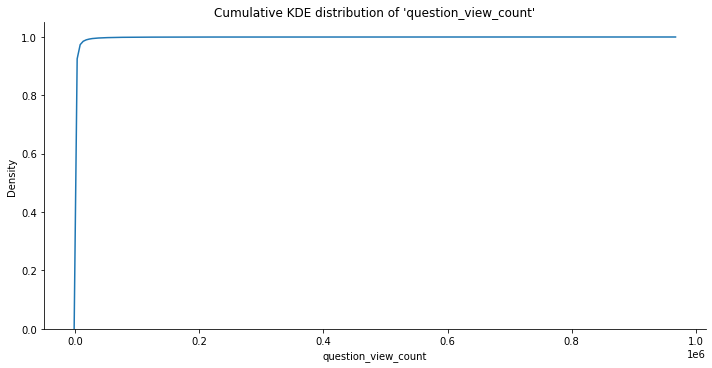

In [114]:

plt.figure()
sns.displot(so_QA_tags['question_view_count'], kind='kde', bw_adjust=.1, aspect=2)
plt.title("KDE distribution of 'question_view_count'")
plt.show()

plt.figure()
sns.displot(so_QA_tags['question_view_count'], kind='kde', cumulative=True, aspect=2)
plt.title("Cumulative KDE distribution of 'question_view_count'")
plt.show()

<function matplotlib.pyplot.show>

<Figure size 432x288 with 0 Axes>

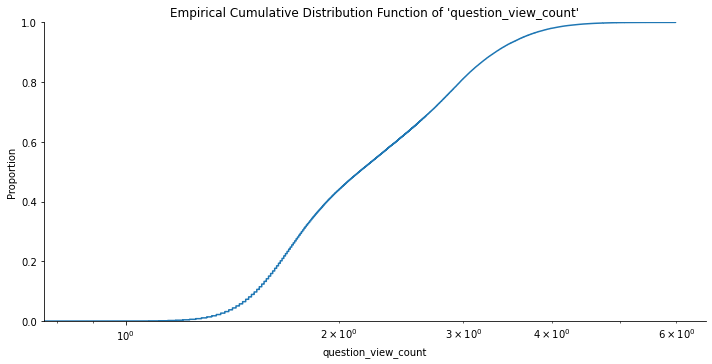

In [115]:
plt.figure()
sns.displot(x='question_view_count', data=so_QA_tags, kind='ecdf', height=5, aspect=2, log_scale=True)
plt.title("Empirical Cumulative Distribution Function of 'question_view_count'")
plt.show

#### <font color='red'>Setting popularity labels </font>
The distribution appears to skew to the right and the majority of the curve is far left of the mean (1211) and most posts will experience ~37 views. These metrics in tandem with a cumulative distribution plot can help us split the posts into 3 groups that represent 3 different sections of the distribution.  

Given a normal distribution, the 3 groups could be selected based on the mean and its standard deviations.  Because of the skewness, these metrics will not allow a simple division of the distribution. This is a problem because of how large the  is compared to the 
- mean = 1211 <br>
- 1 std = 7036 views <br>
- mode = 37 <br>
- max number of views = 965492 <br>
- min number of views = 7 <br>

This data naturally has a lot of outliers as seen in the distribution charts.  Based on the cumulative distribution plot, posts beyond ~37 views accounts for only 5% of the data.  The majority of the data is represented by posts that don't have more than 30 views.  

To solve our original problem we only need to determine what makes a post have an exceptionally high number of views as opposed to posts that see an average amount of views and those that barely see any views.  

Judging from the distribution plots, the sections can be broken down as such:

- top: question_view_count > 250
- mid: 15 < question_view_count < 250 
- bot: question_view_count < 15


*TOP*<br>
Posts that have an exceptionally high amount of views that account for ~10% of the data. These posts also happen to include the mean and posts that are several standard deviations above. 

*MIDDLE*<br>
Posts that includes the vast majority where views are.  These posts have an average amount of views and account for ~85% of the data

*BOTTOM*<br>
Posts that are barely viewed even though there is an acceptable answer.  These questions are rare likely due to the newness of the post or because the question is either too trivial, very specialized in nature, or some other unknown reason. 

-------------------------------
Labeling the posts based on these metrics will help us determine what key words in the question or answer affect the view counts for the posts that include the 'python' tag in the last 5 years.

In [116]:
so_QA_tags['dist_section'] = np.where(so_QA_tags['question_view_count'] > 250, 'Top', np.where(so_QA_tags['question_view_count'] > 15, 'Middle', 'Bottom'))
so_QA_tags['dist_section'].value_counts()

Middle    118576
Top        80514
Bottom       589
Name: dist_section, dtype: int64

### Beautiful Soup

In [117]:
# converting html to text

def soup_lxml(text):
  soup = BeautifulSoup(text, 'lxml')
  html_free = soup.get_text()
  return html_free

def soup_html(text):
  soup = BeautifulSoup(text, 'html.parser')
  html_free = soup.get_text()
  return html_free

def remove_next_line(text):
  new_text =  re.sub("\n", "", text)
  return new_text



In [118]:
# Initializing an example post as test data

test_html = so_QA_tags.loc[1, 'post_answer']
print(test_html)

<p>You create lists:</p>
<pre><code>accuracy = []
precision = []
recall = []
f1 = []
...
</code></pre>
<p>and you define scores to hold these lists:</p>
<pre><code>scores = [accuracy, precision, recall, f1]
</code></pre>
<p>Then you iterate over these lists:</p>
<pre><code>for score in scores:
   ...
</code></pre>
<p>But inside that loop you use these lists as if they're functions:</p>
<pre><code>score(y_test, predictions)
</code></pre>


#### Using different parsers to remove html tags

In [119]:

print("\n================== lxml ===================\n")
# using lxml parser

test_text_lxml = soup_lxml(test_html)
print(test_text_lxml)


print("\n===============  html.parser ===============\n")
# using html.parser parser

test_text_html = soup_html(test_html)
print(test_text_html)


================== lxml ===================

You create lists:
accuracy = []
precision = []
recall = []
f1 = []
...

and you define scores to hold these lists:
scores = [accuracy, precision, recall, f1]

Then you iterate over these lists:
for score in scores:
   ...

But inside that loop you use these lists as if they're functions:
score(y_test, predictions)


===============  html.parser ===============

You create lists:
accuracy = []
precision = []
recall = []
f1 = []
...

and you define scores to hold these lists:
scores = [accuracy, precision, recall, f1]

Then you iterate over these lists:
for score in scores:
   ...

But inside that loop you use these lists as if they're functions:
score(y_test, predictions)



#### Removing \n
When printed, the output will handle the \n as newlines.  This is not the same case when tokenizing an un-printed string.<br>
They will have to be removed and formatting will be lost when printing.

In [120]:
cleaned_text = remove_next_line(test_text_html)
cleaned_text

"You create lists:accuracy = []precision = []recall = []f1 = []...and you define scores to hold these lists:scores = [accuracy, precision, recall, f1]Then you iterate over these lists:for score in scores:   ...But inside that loop you use these lists as if they're functions:score(y_test, predictions)"

#### Extracting html elements like links
This should be done prior to extracting text since the tags need to be located. <br>
Create new soup.

In [121]:
test_soup = BeautifulSoup(test_html, "html.parser")
test_links = test_soup.find_all('a')
test_links

[]

2 ways to retrieve hyperlinks

In [122]:
for link in test_links:
  print("Text for hyperlink: {}".format(link.text))
  print("Attributes of links: {}".format(link.attrs))
  print("Link from href: {}".format(link.attrs['href']))

for link in test_soup.find_all('a'):
  print(link.get('href'))

#### Other Basic BeautifulSoup methods


In [123]:
# View the way tags are nested
print("============ prettify ============")
print(test_soup.prettify())

# Find titles
print("=========== title =============")
print(test_soup.title)

# Find p tags
print("============ p ============")
print(test_soup.p)

# Find links
print("=========== a =============")
print(test_soup.a)

# Find links
print("============ find_all a ============")
test_soup.find_all('a')

# Find text
print("=========== find_all text =============")
parsed_text = test_soup.find_all(text=True)
parsed_text

============ prettify ============
<p>
 You create lists:
</p>
<pre><code>accuracy = []
precision = []
recall = []
f1 = []
...
</code></pre>
<p>
 and you define scores to hold these lists:
</p>
<pre><code>scores = [accuracy, precision, recall, f1]
</code></pre>
<p>
 Then you iterate over these lists:
</p>
<pre><code>for score in scores:
   ...
</code></pre>
<p>
 But inside that loop you use these lists as if they're functions:
</p>
<pre><code>score(y_test, predictions)
</code></pre>
=========== title =============
None
============ p ============
<p>You create lists:</p>
=========== a =============
None
============ find_all a ============
=========== find_all text =============


['You create lists:',
 '\n',
 'accuracy = []\nprecision = []\nrecall = []\nf1 = []\n...\n',
 '\n',
 'and you define scores to hold these lists:',
 '\n',
 'scores = [accuracy, precision, recall, f1]\n',
 '\n',
 'Then you iterate over these lists:',
 '\n',
 'for score in scores:\n   ...\n',
 '\n',
 "But inside that loop you use these lists as if they're functions:",
 '\n',
 'score(y_test, predictions)\n']

#### Apply BeautifulSoup to post_question column to create cleaned up data

In [124]:
# use beautiful soup function to clean up html tags in the question
so_QA_tags['bSoup_question'] = so_QA_tags['post_question'].map(soup_html)

# use function to remove \n from raw question data
so_QA_tags['bSoup_question'] = so_QA_tags['bSoup_question'].map(remove_next_line)

In [125]:
so_QA_tags['bSoup_question'].iloc[:2]

0    I´m currently trying to customize the error ha...
1    I am creating a model using SVM. I wanted to s...
Name: bSoup_question, dtype: object

### NLTK

Using NLTK to clean up text and extract info to deterine the most used tokens.

In [178]:
import nltk
import string

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [129]:
# remove_puncutation
def remove_punctuation(text):
  try:
    no_punct = "".join(c for c in text if c not in string.punctuation)
    return no_punct
  except (AttributeError, TypeError):
    raise AssertionError('Input variable should be a string')

In [130]:
ting_punc = pd.Series(data=["punc_STUFF like: ' ! @tag #tag %f 2^4 3*6 (par) They're ",
                            "! @ # $ % ^ & * ( ) - + ' . , / \ ",
                            "tokenize this $4 $tuff for me a of plz.."])
display(ting_punc)

0    punc_STUFF like: ' ! @tag #tag %f 2^4 3*6 (par...
1                   ! @ # $ % ^ & * ( ) - + ' . , / \ 
2             tokenize this $4 $tuff for me a of plz..
dtype: object

We may not want to remove punctuation that might degrade formulaic or programming notations.

In [166]:
# nltk tokenizer turns string into list of words
def tokenize_nltk(text, mode='default', case=None):
  """
  mode:
    space - tokenizes based on spaces as delimiters
    word - tokenizes based on words
    punkt - tokenizes based on punkt lexicon
  case:
    None - maintains case
    lower - transforms all tokens to lower case
  """
# ‘\w+|\$[\d\.]+|\S+’ # splits up by space or periods that are not attached to a digit

  if mode == 'space':
    nltk_tokenizer = RegexpTokenizer(r'\s+', gaps=True)
  
  elif mode == 'word':
    nltk_tokenizer = RegexpTokenizer(r'\w+')

  elif mode == 'default':
    tokenized = word_tokenize(text)

    if case == 'lower':
      print("lowering")
      tokenized_lower = [x.lower() for x in tokenized]
      print(type(tokenized))
      print(tokenized)
      #tokenized_lower = tokenized.lower()
      return tokenized_lower
    else:
      return tokenized

  if case == 'lower':
    tokenized = nltk_tokenizer.tokenize(text.lower())
  else:
    tokenized = nltk_tokenizer.tokenize(text)
  
  return tokenized

In [167]:
print("space")
ting_toke = ting_punc.apply(lambda x: tokenize_nltk(x, mode='space'))
display(ting_toke)
print("word")
ting_toke = ting_punc.apply(lambda x: tokenize_nltk(x, mode='word', case='lower'))
display(ting_toke)
print("default")
ting_toke = ting_punc.apply(lambda x: tokenize_nltk(x, mode='default', case='lower'))
display(ting_toke)


space


0    [punc_STUFF, like:, ', !, @tag, #tag, %f, 2^4,...
1    [!, @, #, $, %, ^, &, *, (, ), -, +, ', ., ,, ...
2    [tokenize, this, $4, $tuff, for, me, a, of, pl...
dtype: object

word


0    [punc_stuff, like, tag, tag, f, 2, 4, 3, 6, pa...
1                                                   []
2       [tokenize, this, 4, tuff, for, me, a, of, plz]
dtype: object

default
lowering
<class 'list'>
['punc_STUFF', 'like', ':', "'", '!', '@', 'tag', '#', 'tag', '%', 'f', '2^4', '3*6', '(', 'par', ')', 'They', "'re"]
lowering
<class 'list'>
['!', '@', '#', '$', '%', '^', '&', '*', '(', ')', '-', '+', "'", '.', ',', '/', '\\']
lowering
<class 'list'>
['tokenize', 'this', '$', '4', '$', 'tuff', 'for', 'me', 'a', 'of', 'plz..']


0    [punc_stuff, like, :, ', !, @, tag, #, tag, %,...
1    [!, @, #, $, %, ^, &, *, (, ), -, +, ', ., ,, ...
2    [tokenize, this, $, 4, $, tuff, for, me, a, of...
dtype: object

In [172]:
# remove stopwords
def remove_stopwords(text):
  
  sans_stopwords = [word for word in text if word not in stopwords.words('english')]
  return sans_stopwords


In [176]:
ting_toke.apply(remove_stopwords)

0    [punc_stuff, like, :, ', !, @, tag, #, tag, %,...
1    [!, @, #, $, %, ^, &, *, (, ), -, +, ', ., ,, ...
2                     [tokenize, $, 4, $, tuff, plz..]
dtype: object

In [ ]:
# nltk lemmatizer
def lemmatize_nltk(text):
  # Assert list of words
  
  lemmatizer = WordNetLemmatizer()
  lem_text = [lemmatizer.lemmatize(word) for word in text]
  return lem_text

In [195]:
pre_lem_string = pd.Series(data=[
                          "helping did these fights things were fighting"
])
pre_lem_words = pre_lem_string.apply(tokenize_nltk)
print(pre_lem_words)
lem_words = pre_lem_words.apply(lemmatize_nltk)
print(lem_words)

0    [helping, did, these, fights, things, were, fi...
dtype: object
0    [helping, did, these, fight, thing, were, figh...
dtype: object


In [192]:
lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize("fights")

'fight'

In [189]:
# nltk stemmer (Porter)
def porter_stemmer_nltk(text):
  # assert list of words
  stemmer = PorterStemmer()
  stemmed_text = [stemmer.stem(word) for word in text]
  
  return stemmed_text

In [196]:
stem_words = pre_lem_words.apply(porter_stemmer_nltk)
stem_words

0    [help, did, these, fight, thing, were, fight]
dtype: object

In [212]:
# complete function
def nltk_text_processing(pd_series, punc=False, stop=True, lem=True, stem=True):
  if isinstance(pd_series, pd.Series):
    print("pd_series is a Series")

    if punc:
      # remove punctuation.  string remains string
      pd_series = pd_series.apply(remove_punctuation)
      print(f"sans_punctuation type: {type(sans_punctuation)}")

    # tokenize.  string becomes list
    words = pd_series.apply(tokenize_nltk)
    print(f"words type: {type(words)}")
    
    if stop:
      # remove stopwords.  list remains list
      words = words.apply(remove_stopwords)
      print(f"sans_stopwords type: {type(words)}")
    
    if lem:
      # lemmatize.  list remains list
      words = words.apply(lemmatize_nltk)
      print(f"lemmatized type: {type(words)}")

    if stem:
      # stemmer. list remains list
      words = words.apply(porter_stemmer_nltk)
      print(f"stemmed type: {type(words)}")

    return words
    

In [200]:
so_QA_tags['bSoup_question'].iloc[:5]

0    I´m currently trying to customize the error ha...
1    I am creating a model using SVM. I wanted to s...
2    I created a form with Django forms. I implemen...
3    Snippet of my code implementation on PyTorch i...
4    I am trying to write a regex in Python for fin...
Name: bSoup_question, dtype: object

In [214]:
nltk_series = nltk_text_processing(so_QA_tags['bSoup_question'].iloc[:5], stem=False)
nltk_series

pd_series is a Series
words type: <class 'pandas.core.series.Series'>
sans_stopwords type: <class 'pandas.core.series.Series'>
lemmatized type: <class 'pandas.core.series.Series'>


0    [I´m, currently, trying, customize, error, han...
1    [I, creating, model, using, SVM, ., I, wanted,...
2    [I, created, form, Django, form, ., I, impleme...
3    [Snippet, code, implementation, PyTorch, :, mo...
4    [I, trying, write, regex, Python, finding, eve...
Name: bSoup_question, dtype: object

#### Use NLTK to find most common tokens in the questions, answers, and tags


#### NLTK N-Grams

Finding the most common tags
- split by delimiter "|"
- tokenize using sklearn.multilabelencoder
- count the max in each tag column



In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer


In [ ]:
# create tags_list column
so_QA_tags['tags_list'] = so_QA_tags['tags'].apply(lambda x: list(x.split('|')))
so_QA_tags['tags_list'].head(5)

In [ ]:
mlb = MultiLabelBinarizer()
mlb_df = pd.DataFrame(mlb.fit_transform(so_QA_tags['tags_list', columns=mlb.classes_))


In [ ]:
so_QA_tags = pd.concat(so_QA_tags, mlb_df, axis=1)

COUNT MAX OF sum(column) in mlb_df = most occuring tags



### Spacy

Spacy intialization
- Initializing pipeline
- input text

In [ ]:
print(spacy.__version__)
nlp = spacy.load('en')

In [ ]:
print(cleaned_text)
doc = nlp(cleaned_text)
print(doc)

#### Tokenizer
- automatically tokenized by the pipeline

In [ ]:
# Print all tokens.  If cleaned_text was used instead, each token would be a letter

for token in doc:
  print(token)

#### Lemmatization and Stopword display
- token.lemma_
- token.is_stop

In [ ]:
print(f"Token \t\tLemma \t\tStopword")
print("-"*40)
for token in doc:
  print(f"{str(token)}\t\t{token.lemma_}\t\t{token.is_stop}")


#### Matching Phrases
- captures token_id
- start and end positions

In [ ]:
from spacy.matcher import PhraseMatcher
matcher = PhraseMatcher(nlp.vocab, attr='LOWER')

key_terms = ['accuracy', 'precision', 'f1']
patterns =  [nlp(text) for text in key_terms]
matcher.add("TerminologyList", patterns)

In [ ]:
print(test_text_html)
text_doc = nlp(test_text_html)
matches = matcher(text_doc)
print(matches)

The matches are a tuple of (match_id, start pos, end pos)

In [ ]:
match_id, start, end = matches[0]
print(nlp.vocab.strings[match_id], text_doc[start:end])

- finding tags in a post entry
- using iterrows()

#### Bag of Words


In [ ]:
# create an empty model without pipes
nlp = spacy.blank("en")

# create TextCategorizer with exclusive classes and "bow" (bag of words) architecture
textcat = nlp.create_pipe(
    "textcat",
    config={
        # check other params
        "exclusive_classes": True,  # used if each row had known labels like "spam"
        "architecture": "bow"
    }
)

nlp.add_pipe(textcat)


In [ ]:
# Add labels to the text classifier
textcat.add_label("Top")
textcat.add_label("Middle")
textcat.add_label("Bottom")
textcat.labels

#### Perform train test split for sample data and also reserve test data



In [ ]:
so_QA_tags.columns

In [ ]:
so_QA_tags = so_QA_tags.reset_index(drop=True)

y = so_QA_tags['dist_section']
X = so_QA_tags['bSoup_question']

In [ ]:
# sample 10 
X_remaining, X_test, y_remaining, y_test = train_test_split(X, y, test_size=.9, stratify=y, random_state=9) 
tts = [X_remaining, X_test, y_remaining, y_test]

X_train, X_validation, y_train, y_validation = train_test_split(X_remaining, y_remaining, test_size=.3, stratify=y_remaining, random_state=9) 
tts = [X_train, X_validation, y_train, y_validation]

In [ ]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]


for dataset in tts:
  print(f"{namestr(dataset, globals())[0]:20} {dataset.shape}")

#### Apply Spacy to new bSoup_questions column to get token data and create model

In [ ]:
train_texts = X_train.values
train_labels = [{'cats': {'Top': label == 'Top',
                                  'Middle': label == 'Middle',
                                  'Bottom': label == 'Bottom'}}
                for label in y_train]
      
train_data = list(zip(train_texts, train_labels))
train_data[:2]

In [ ]:
import random
from spacy.util import minibatch

spacy.util.fix_random_seed(1)
optimizer = nlp.begin_training()

losses = {}
for epoch in range(10):
  random.shuffle(train_data)

  # Create the batch generator with batch size = 8
  batches = minibatch(train_data, size=512)

  # Iterate through minibatches
  for batch in batches:
    # a batch is a tuple of (text, label) and needs to be split to be able to run update()
    texts, labels = zip(*batch)
    nlp.update(texts, labels, sgd=optimizer, losses=losses)
  print(losses)

In [ ]:
def predict(nlp, texts):
  docs = [nlp.tokenizer(text) for text in texts]

  textcat = nlp.get_pipe('textcat')
  scores, _ = textcat.predict(docs)

  predicted_class = scores.argmax(axis=1)
  print(scores)
  return predicted_class

  

In [ ]:
test_text = X_test[:1]
print(test_text)
y_test[:1]

In [ ]:
predict(nlp, test_text)

In [ ]:
def evaluate(model, texts, labels):
  predicted_class = predict(model, texts)
  true_class = np.where(y_test == "Top", 2, np.where(y_test == "middle", 1, 0))
  correct_predictions = predicted_class == true_class

  accuracy = correct_predictions.mean()
  return accuracy



In [ ]:
accuracy = evaluate(nlp, X_test, y_test)

#### Predictions


# Run query to get tag activity by posts_questions tags and question creation_date and last_activity date.
feed query data into visualization for time-series analysis on tag activity in last 10 years.

- javascript
- python
- scala
- c#
- php
- ruby
- linux
